#**Segmentación de ECG usando Deep Learning - Complejo QRS usando redes LSTM**


Este `notebook`está basado en el paper [**Deep Learning for ECG Segmentation**](https://arxiv.org/abs/2001.04689)  de *Viktor Moskalenko, Nikolai Zolotykh, Grigory Osipov* aunque con varias diferencias significativas. Por ejemplo, en la arquitectura de la red y en el objetivo: en este notebook nos limitamos a la segmentación del complejo QRS.



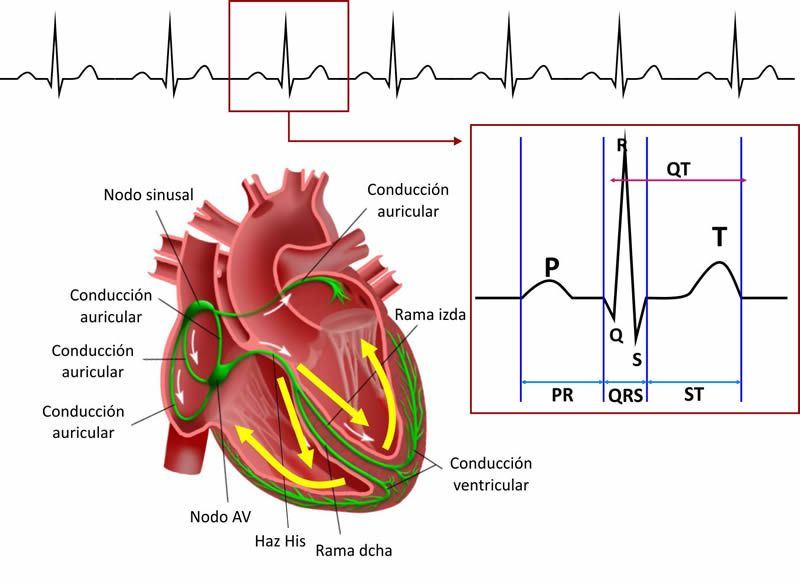

Fuente: https://ecocardio.com/documentos/biblioteca-preguntas-basicas/preguntas-al-cardiologo/1046-complejo-qrs.html

### **Instalar wfdb**

In [ ]:
!pip install wfdb --quiet

In [ ]:
import math
import wfdb
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
%matplotlib inline

### **Obtener dataset: Lobachevsky University Database (LUDB)**

Esta base de datos es descrita en el trabajo [LU electrocardiography database: a new open-access validation tool for delineation algorithms](https://arxiv.org/abs/1809.03393) de **Alena I. Kalyakulina, Igor I. Yusipov, Victor A. Moskalenko, Alexander V. Nikolskiy, Artem A. Kozlov, Nikolay Yu. Zolotykh, Mikhail V. Ivanchenko.** del año 2018.

 [Lobachevsky University Database (LUDB)](http://www.cyberheart.unn.ru/database) contiene 200 registros de 200 sujetos. La señal ECG fue capturada en el proyecto Cyberheart con el apoyo del Ministerio de Educación de la Federación Rusa en el **Institute of Information Technology, Mathematics and Mechanics, Nizhny Novgorod Lobachevsky State University**. La anotación manual de las señales electrocardiográficas  y diagnósticos fueron realizados por doctores de  organizaciones médicas de [Nizhny Novgorod](https://es.wikipedia.org/wiki/Nizhni_N%C3%B3vgorod).

![](https://www.mmemed.com/wp-content/uploads/2017/02/schiller_AT-101_ecg_machine.jpg)

Las grabaciones de ECG se realizaron con el cardiógrafo **Schiller Cardiovit AT-101** con los 12 leads estándares **(i, ii, iii, avr, avl, avf, v1, v2, v3, v4, v5, v6)** y una duración de 10 segundos. La frecuencua de muestreo fue de 500 muestras por segundo.  Los límites y picos del QRS, ondas P y T fueron determinados manualmente por cardiólogos. En total la base contiene: 58429 ondas (21966 QRS, 19666 T, 16797 P), si se consideran las derivadas de manera independiente.

Los ECGs fueron colectados por voluntarios sin patologías y por pacientes con varias condiciones cardiacas, algunos de los pacientes tienen marcapasos. La edad de los sujetos va de 11 a 90 años, siendo la edad promedio de 52 años. La distribución de género: 85 mujeres y 115 hombres.

In [ ]:
!wget -q -O ludb.zip http://server01.labs.org.pe:2005/ludb.zip
!unzip -qq ludb.zip

### **Lectura de los registros**

Comenzamos seleccionando un registro, leeremos la señal junto con la metadata

In [ ]:
id = 50
record = wfdb.rdsamp('ludb/{}'.format(id))
signal = record[0]
metadata = record[1]

Podemos ver todos los archivos para ese registro en particular

In [ ]:
!ls ludb/$id\.*

Podemos ver en la metadata las derivadas disponibles

In [ ]:
derivadas = metadata['sig_name']
derivadas

Podemos ver el resto de la metadata

In [ ]:
pd.DataFrame(metadata.values(), index=metadata.keys())

In [ ]:
print("La señal tiene {} muestras con una frecuencia de muestreo de {} Hz, por lo tanto, la duración es de {} seg.".format(metadata['sig_len'], metadata['fs'], metadata['sig_len']/metadata['fs']))

... también podemos enforcarnos en el campo `comments` que incluye la información del paciente y diagnóstico.

In [ ]:
metadata['comments']

Asimismo, podemos mostrar las señales de todas las derivadas

In [ ]:
plt.figure(figsize=(20,10))
plt.suptitle('Paciente {}'.format(id))
for i, derivada in enumerate(derivadas):
  ext = "atr_{}".format(derivada)
  atr = wfdb.rdann('ludb/{}'.format(id), extension=ext) #lectura de los atributos
  plt.subplot(12,1,i+1)
  plt.plot(signal[:,i], color='k', label=derivada)
  plt.legend(loc=1)

Podemos verificar las anotaciones para alguna de las derivadas

Nota: El complejo **QRS** está anotado con **N**, y el inicio y final está anotado con paréntesis. La onda t y la onda p están marcadas con las letras correspondietes.

In [ ]:
idx = 0
signal_i = signal[:,idx]
derivada = metadata['sig_name'][idx]
ext = "atr_{}".format(derivada)
attr = wfdb.rdann('ludb/{}'.format(id), extension=ext)
pd.DataFrame(zip(attr.sample, attr.symbol), columns=['# muestra', 'anotación']).T

A continuación vamos a implementar una función para extraer las anotaciones del complejo QRS (marcadas con **N**)

In [ ]:
def get_annotation(attr, symbol='N'):
  symbols = np.array(attr.symbol)
  samples = np.array(attr.sample)
  qrs_peak_idx = np.argwhere(symbols==symbol).ravel()
  qrs_start_idx = qrs_peak_idx - 1
  qrs_end_idx = qrs_peak_idx + 1
  qrs_start_end_idx = np.concatenate([qrs_start_idx,qrs_end_idx])
  qrs_start_end_idx.sort()
  return samples[qrs_start_end_idx]

Podemos ver los puntos de inicio y final de cada completo QRS

In [ ]:
anotaciones = get_annotation(attr, symbol='N')
anotaciones

In [ ]:
plt.figure()
plt.xlabel("Muestra")
plt.ylabel("Voltage (mV)")
plt.title("Paciente {} Derivada {}".format(id, derivada))
plt.vlines(anotaciones, signal_i.min(), signal_i.max(), color='r', linestyles='--', alpha=0.5)
plt.plot(signal_i, color='k')

Eso lo podemos convertir a un arreglo binario (paralelo a la señal) de modo que haya 1's cuando estemos "dentro" del complejo QRS y 0 afuera.

In [ ]:
def get_QRS_target(attr, size=5000):
  target = np.zeros(size)
  segments = get_annotation(attr, 'N')
  segments = segments.reshape(-1,2)
  for s in segments:
    target[s[0]:s[1]]=1
  return target

In [ ]:
anotacion_binaria = get_QRS_target(attr, 5000)
anotacion_binaria

In [ ]:
plt.figure()
plt.title("Paciente {} Derivada {}".format(id, derivada))
plt.xlabel("Muestra")
plt.ylabel("Voltage (mV)")
plt.plot(signal_i, color='k')
plt.plot(anotacion_binaria*signal_i.max(),color='r', alpha=0.5, label='Anotacion')
plt.legend(loc=1)

## **Procesamiento del dataset**

En esta sección usamos las funciones definidas previamente `get_QRS_target` para crear el ground truth con el cual entrenaremos la red neuronal.

In [ ]:
x = []
y = []
derivada_idx = 1
for id in range(1,201):
  datos = wfdb.rdsamp('ludb/{}'.format(id))
  signal = datos[0]
  metadata = datos[1]
  derivadas = metadata['sig_name']
  derivada = derivadas[derivada_idx]
  try:
    ext = "atr_{}".format(derivada)
    attr = wfdb.rdann('ludb/{}'.format(id), extension=ext)
    y.append(get_QRS_target(attr, len(signal[:,derivada_idx])))
    x.append(signal[:,derivada_idx])
  except:
    print("Error en el paciente {}".format(id))
x = np.vstack(x)
y = np.vstack(y)

x = x[:, 452:4548]
y = y[:, 452:4548]
x.shape, y.shape

max_sequence_length = 4096
X = pad_sequences(x, maxlen=max_sequence_length, padding='post')
y = pad_sequences(y, maxlen=max_sequence_length, padding='post')

# Splitting the data
x_train, x_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

# Reshaping data for LSTM input
x_train = np.expand_dims(x_train, axis=2)
x_val = np.expand_dims(x_val, axis=2)

### **Definimos la arquitectura de la red recurrente**

In [ ]:
from keras.models import Sequential
from keras.layers import LSTM, Dense, TimeDistributed

model = Sequential()
model.add(LSTM(64, return_sequences=True, input_shape=(max_sequence_length, 1)))
model.add(LSTM(64, return_sequences=True))
model.add(TimeDistributed(Dense(1, activation='sigmoid')))

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])


# Training the model
log = model.fit(x_train, y_train, epochs=50, batch_size=32, validation_data=(x_val, y_val))


### **Verifiquemos las curvas de entrenamiento y métricas**

In [ ]:
plt.figure()
plt.title("Loss x epoch")
plt.plot(log.history['loss'], label='train')
plt.plot(log.history['val_loss'], label='test')
plt.xlabel('epoch');
plt.ylabel('loss')
plt.legend()
plt.show()


In [ ]:
plt.figure()
plt.title("Accuracy x epoch")
plt.plot(log.history['accuracy'], label='train')
plt.plot(log.history['val_accuracy'], label='test')
plt.xlabel('epoch');
plt.ylabel('accuracy')
plt.legend()
plt.show()

In [ ]:
loss, accuracy = model.evaluate(x_val, y_val)
print(f'Test Loss: {loss}, Test Accuracy: {accuracy}')

## **Resultados**

In [ ]:
y_predicted = model.predict(x_val)

### Mostremos todos los gráficos

In [ ]:
#@title Mostrar los resultados { run: "auto" }
th = 0.53 #@param {type:"slider", min:0, max:1, step:0.01}
idx = 19 #@param {type:"slider", min:1, max:20, step:1}

plt.figure(figsize=(30,6))
plt.plot(x_val[idx,:], color='k')
plt.ylim(-2000,2000)
plt.fill_between(np.arange(4096),
                (y_predicted[idx,:,0]>th)*2000,
                (y_predicted[idx,:,0]>th)*-2000,
                alpha=0.4,
                color='red')
plt.show()




# **Direcciones de exploración**



- Probar otras redes recurrentes (GRU, LSTM, Vanilla en la versión directa y la bidireccional también)
- Cambiar las dimensiones o agregar más profundidad
- Usar todas las derivadas y no solo una